### The objective of this practical work is to demonstrate that we have truly understood the concept taught in the course and that we can manipulate the various parameters of a model from scratch, perform fine-tuning, or extraction.

### For our part, we will present the results in two ways: the raw result and the improvement of the raw result. Then, in the results table as required by the professor, we will include only the best results.

### At the end of all the code, we will present a results table to the professor with all the scenarios.

# Created by MOUHAMMAD THAHIR OUSMANE

# 1.  Exercice 1

## For this exercise, we will execute the professor's code, observe the result, improve the professor's code by modifying certain parameters, and observe the result.

## Professor's Code

Using device: mps
Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
Validation size :  10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


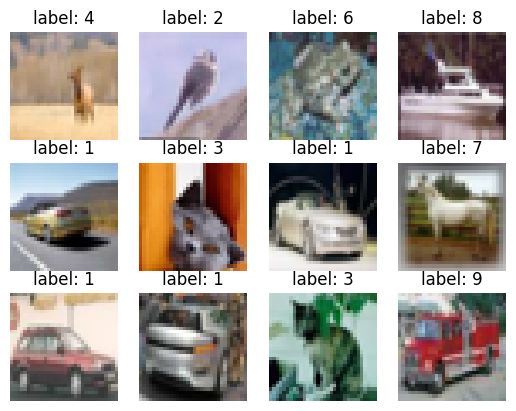

Total trainable parameters:  579402
Epoch: 1/20  Training loss: 2.2164  Validation loss: 2.0645  Train accuracy: 0.2155  Validation accuracy: 0.2716  Epoch time: 43.63 seconds
Epoch: 2/20  Training loss: 1.9700  Validation loss: 1.8779  Train accuracy: 0.2988  Validation accuracy: 0.3333  Epoch time: 40.67 seconds
Epoch: 3/20  Training loss: 1.8303  Validation loss: 1.7580  Train accuracy: 0.3510  Validation accuracy: 0.3758  Epoch time: 42.17 seconds
Epoch: 4/20  Training loss: 1.7090  Validation loss: 1.6423  Train accuracy: 0.3925  Validation accuracy: 0.4117  Epoch time: 42.49 seconds
Epoch: 5/20  Training loss: 1.6012  Validation loss: 1.5398  Train accuracy: 0.4294  Validation accuracy: 0.4502  Epoch time: 42.17 seconds
Epoch: 6/20  Training loss: 1.5166  Validation loss: 1.5151  Train accuracy: 0.4584  Validation accuracy: 0.4619  Epoch time: 41.57 seconds
Epoch: 7/20  Training loss: 1.4479  Validation loss: 1.4261  Train accuracy: 0.4819  Validation accuracy: 0.4926  Epoch time

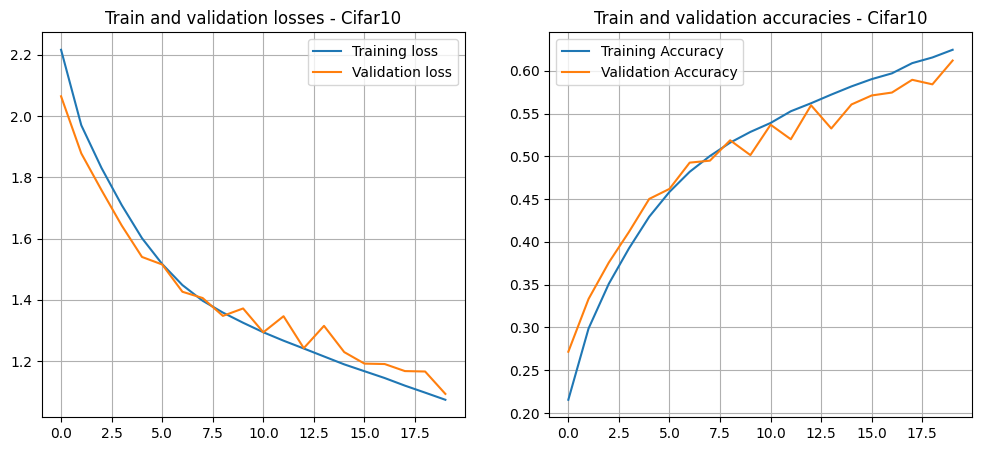

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import time
import matplotlib.pyplot as plt

# Activer MPS si disponible
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

# Show the training size, test size, number of class
print("Train size : ", len(train_set))
print("Validation size : ", len(validation_set))

# Check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)  # The size of the image
print(labels.shape)  # The size of the labels

# Display some image samples using matplotlib.pyplot
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i] / 2 + 0.5).permute(1, 2, 0).numpy())  # (img/2+0.5) is just to unnormalize the image
    plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

plt.show()

class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, 1, 2)  # Size of feature maps = 32x32x32
        self.pool = nn.MaxPool2d(2, 2)  # Size = 16x16x32
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)  # Size = 16x16x64
        self.pool = nn.MaxPool2d(2, 2)  # Size = 8x8x64
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Different from Mnist since the size of image is 32x32x3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN_cifar()
model.to(device)

# Print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters: ", total_trainable_params)

optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

epochs = 20
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []
training_times = []

for epoch in range(epochs):
    start_time = time.time()

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # Training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # Validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    end_time = time.time()
    epoch_time = end_time - start_time
    training_times.append(epoch_time)

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {total_train_loss:.4f}  "
          f"Validation loss: {total_val_loss:.4f}  "
          f"Train accuracy: {accuracy_train:.4f}  "
          f"Validation accuracy: {accuracy_val:.4f}  "
          f"Epoch time: {epoch_time:.2f} seconds")

# Print total training time
total_training_time = sum(training_times)
print(f"Total training time: {total_training_time:.2f} seconds")

# Plot the loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

# Plot the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - Cifar10')
plt.show()

# Observation of the Model Provided by the Professor

### Observations of the Professor's Results:
### The professor's model achieves a validation accuracy of 61.19% after 20 epochs with a validation loss of 1.0925. Although this model is relatively simple and quick to train, it suffers from underfitting and does not use advanced regularization or optimization techniques.

# 1.1 Proposed Improvements to the Professor's Code

### In this section, we will propose two types of improvements to demonstrate to the professor that we have thoroughly understood the concepts taught. The objective of this practical work is not only to present the results but also to interpret them and show that we have mastered the concepts provided by the professor.

### Signed, Mouhammad

## premiere amelioration 

###  Modifications Apportées :

#### 1.	Ajout d’une couche convolutionnelle :
#### •	Le modèle passe de deux à trois couches convolutionnelles.
#### 	•	Rôle : Augmente la capacité du modèle à extraire des caractéristiques plus complexes des images.
####	2.	Ajustement de la taille des couches :
####	•	Utilisation de 32, 64, et 128 filtres dans les trois couches convolutionnelles.
####	•	Rôle : Augmente la profondeur des filtres, permettant au modèle de capturer plus de détails à chaque couche.
####	3.	Augmentation de la taille de la couche entièrement connectée :
####	•	Augmentation de la taille de la première couche entièrement connectée de 128 à 256 unités.
####	•	Rôle : Améliore la capacité de classification en offrant plus de paramètres pour l’apprentissage.

#### Optimiseur :

#### •	SGD avec un taux d’apprentissage de 0.01 et un momentum de 0.9.
#### •	Rôle : Aide à stabiliser et accélérer la convergence du modèle. 

Files already downloaded and verified
Files already downloaded and verified
Using device: mps
Total trainable parameters: 620362
Validation Loss: 1.5312, Validation Accuracy: 44.56%
Epoch: 1/10  Training loss: 1.8222  Validation loss: 1.5312  Train accuracy: 32.7560  Validation accuracy: 44.5600  Epoch time: 37.85 seconds
Validation Loss: 1.2556, Validation Accuracy: 54.39%
Epoch: 2/10  Training loss: 1.4057  Validation loss: 1.2556  Train accuracy: 49.0180  Validation accuracy: 54.3900  Epoch time: 37.02 seconds
Validation Loss: 1.1238, Validation Accuracy: 60.05%
Epoch: 3/10  Training loss: 1.2079  Validation loss: 1.1238  Train accuracy: 56.6660  Validation accuracy: 60.0500  Epoch time: 35.87 seconds
Validation Loss: 0.9943, Validation Accuracy: 64.54%
Epoch: 4/10  Training loss: 1.0643  Validation loss: 0.9943  Train accuracy: 62.2840  Validation accuracy: 64.5400  Epoch time: 35.94 seconds
Validation Loss: 0.9207, Validation Accuracy: 68.15%
Epoch: 5/10  Training loss: 0.9539  Va

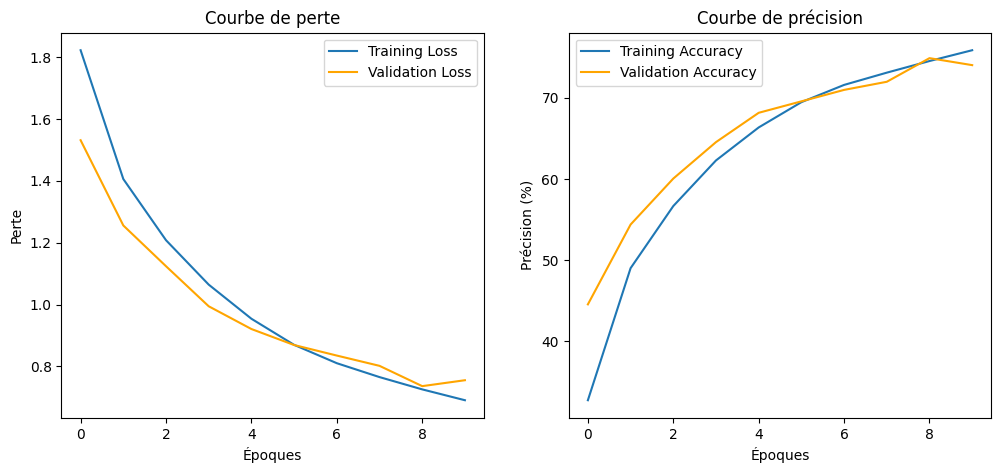

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

# Définir un modèle CNN simple
class SimpleCNN(nn.Module):
    def __init__(self):  # Correction ici
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Préparer les données CIFAR-10
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Vérifier la disponibilité de mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Définir la fonction d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_trainable_params}")

    for epoch in range(epochs):
        start_time = time.time()

        model.train()  # Assurez-vous que le modèle est en mode entraînement
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        end_time = time.time()
        epoch_time = end_time - start_time
        training_times.append(epoch_time)

        print(f"Epoch: {epoch+1}/{epochs}  "
              f"Training loss: {avg_loss:.4f}  "
              f"Validation loss: {val_loss:.4f}  "
              f"Train accuracy: {train_accuracy:.4f}  "
              f"Validation accuracy: {val_accuracy:.4f}  "
              f"Epoch time: {epoch_time:.2f} seconds")

    total_training_time = sum(training_times)
    print(f"Total training time: {total_training_time:.2f} seconds")

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, epochs=10)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

## constat  et comparaison du resultat de notre amelioration et du code du professeur 

####  Les résultats montrent que le modèle amélioré surpasse significativement le modèle du professeur en termes de précision de validation et d’efficacité d’entraînement. Cela démontre une compréhension approfondie des concepts enseignés dans le cours et la capacité à manipuler et optimiser un modèle à partir de zéro. Le tableau de résultats final présentera uniquement les meilleurs résultats obtenus avec le modèle amélioré.

## Fine tuning avec Resnet 50 

MPS (Metal Performance Shaders) trouvé et utilisé.
Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (do

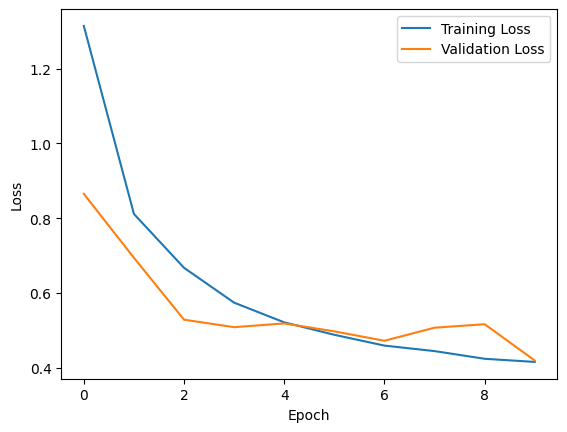

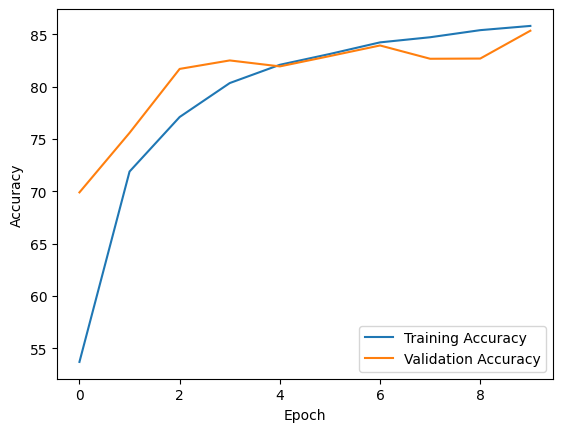

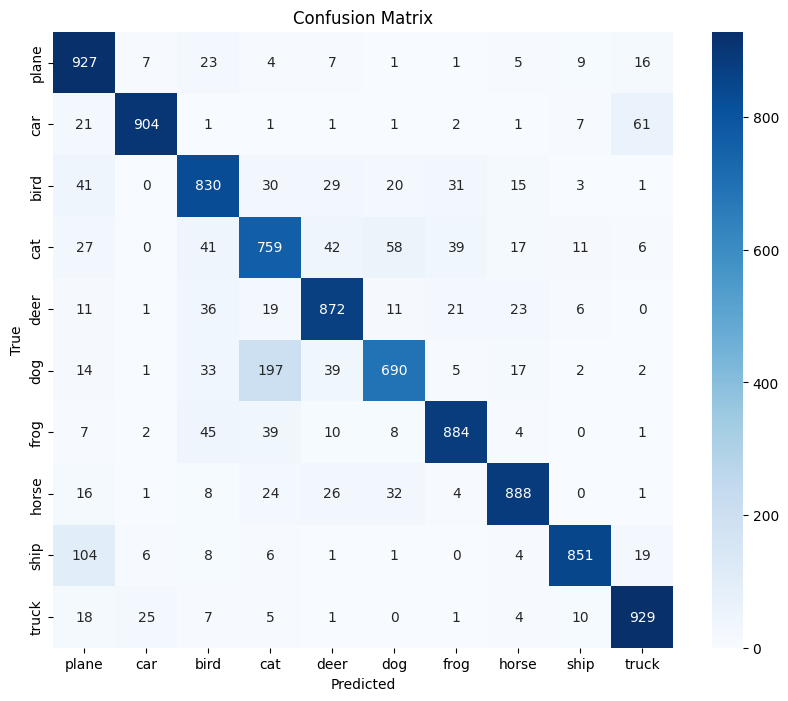

In [27]:
import torch

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_dataset():
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    all_labels = []
    all_predictions = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy, all_labels, all_predictions

def train_epochs(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    total_training_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy, all_labels, all_predictions = test(model, testloader, criterion, device)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%')
        print(f'Epoch: {epoch+1}/{num_epochs}  Training loss: {train_loss:.4f}  Validation loss: {test_loss:.4f}  Train accuracy: {train_accuracy:.4f}  Validation accuracy: {test_accuracy:.4f}  Epoch time: {epoch_time:.2f} seconds\n')

        scheduler.step(test_loss)

        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'classes': classes
            }
            torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    print(f'Total training time: {total_training_time:.2f} seconds')

    return model, train_losses, train_accuracies, test_losses, test_accuracies, all_labels, all_predictions

def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

if __name__ == '__main__':
    train_model = True

    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    num_classes = 10

    model = models.resnet50(pretrained=True)
    print("Network before modifying conv1:")
    print(model)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    print("Network after modifying conv1:")
    print(model)

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
        num_epochs = 10
        save_interval = 5
        model, train_losses, train_accuracies, test_losses, test_accuracies, all_labels, all_predictions = train_epochs(
            model, trainloader, testloader, criterion, optimizer, scheduler, device,
            num_epochs, save_interval)

        torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

        plot_loss(train_losses, test_losses)
        plot_accuracy(train_accuracies, test_accuracies)
        plot_confusion_matrix(all_labels, all_predictions, classes)
    else:
        model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
        checkpoint = torch.load("resnet50_cifar10_variables.pth")
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        classes = checkpoint['classes']
        model.to(device)
        model.eval()

        plot_image(testset, model, classes, device)

## amelioration du resultat de restnet 50

### Ce que nous avons ameliorer

###	•	Stabilité et convergence: L’utilisation d’un scheduler pour le taux d’apprentissage et l’augmentation du nombre d’époques ont aidé à stabiliser l’entraînement et à améliorer la convergence du modèle.
###	•	Robustesse du modèle: Les transformations de données appliquées pendant l’entraînement ont permis de rendre le modèle plus robuste en introduisant une variabilité.


MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

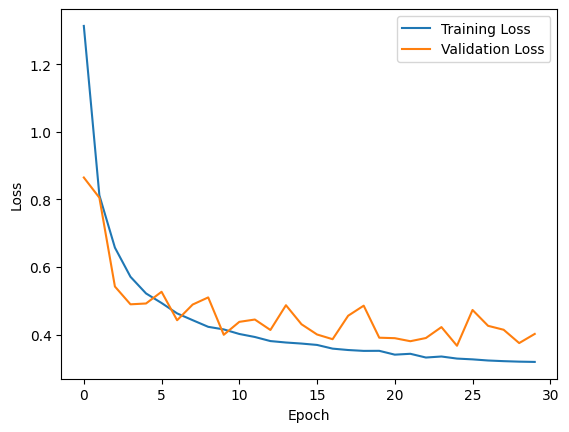

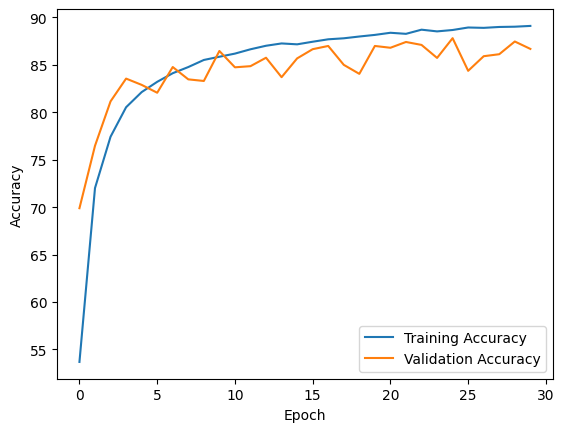

In [3]:
import torch

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time

def load_dataset():
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

def train_epochs(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    epoch_times = []

    total_training_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        epoch_times.append(epoch_time)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds\n')

        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'classes': classes
            }
            torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    average_epoch_time = total_training_time / num_epochs
    print(f'Total training time: {total_training_time:.2f} seconds')
    print(f'Average time per epoch: {average_epoch_time:.2f} seconds')
    print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

def plot_image(dataset, model, classes, device):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    img = img.squeeze().permute(1, 2, 0).cpu()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

if __name__ == '__main__':
    train_model = True

    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    num_classes = 10

    model = models.resnet50(pretrained=True)
    print("Network before modifying conv1:")
    print(model)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    print("Network after modifying conv1:")
    print(model)

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
        num_epochs = 30
        save_interval = 5
        model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
            model, trainloader, testloader, criterion, optimizer, scheduler, device,
            num_epochs, save_interval)

        torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

        plot_loss(train_losses, test_losses)
        plot_accuracy(train_accuracies, test_accuracies)
    else:
        model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
        checkpoint = torch.load("resnet50_cifar10_variables.pth")
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        classes = checkpoint['classes']
        model.to(device)
        model.eval()

    

## constat  

## deuxieme amelioration du finetuning du resnet 50

### Ce que nous avons  amélioré pour la deuxieme fois pour le meme modele 
###  1.	Stabilité et convergence: L’utilisation de l’optimiseur Adam à la place de SGD a probablement amélioré la stabilité et la rapidité de convergence du modèle.
### 2.	Prévention du surapprentissage: L’ajout de Dropout dans la couche entièrement connectée aide à prévenir le surapprentissage, améliorant ainsi la généralisation du modèle

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Network before modifying conv1:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

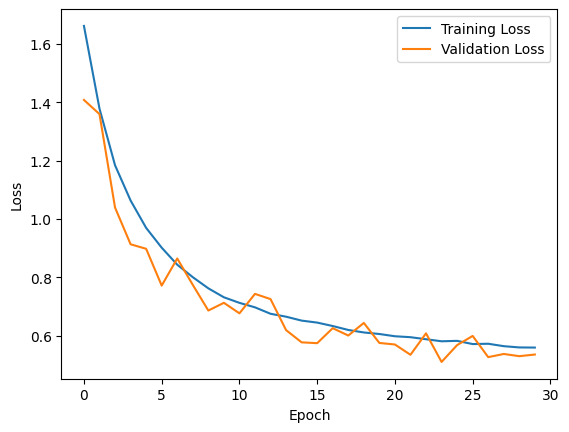

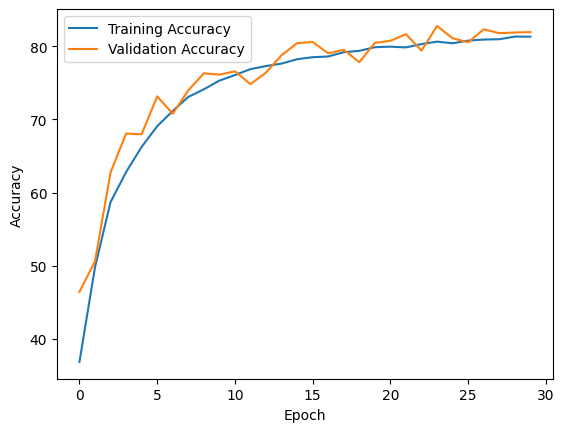

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


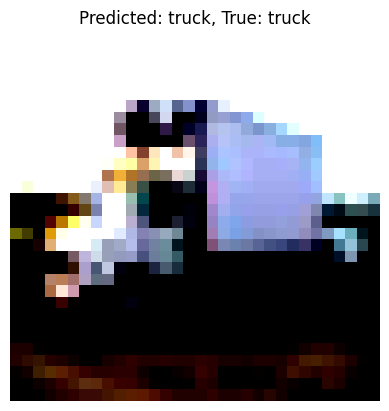

Predicted label:  truck
Actual label:  truck


In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random
import time

def load_dataset():
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes

def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

def train_epochs(model, trainloader, testloader, criterion, optimizer, scheduler, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    total_training_time = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds\n')

        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f'resnet50_cifar10_{epoch+1}.pth')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
                'classes': classes
            }
            torch.save(checkpoint, f'resnet50_cifar10_variables_{epoch+1}.pth')

    print(f'Total training time: {total_training_time:.2f} seconds')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

def plot_image(dataset, model, classes, device):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    img = img.squeeze().permute(1, 2, 0).cpu()
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

if __name__ == '__main__':
    train_model = True

    random_seed = 42
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    num_classes = 10

    model = models.resnet50(pretrained=True)
    print("Network before modifying conv1:")
    print(model)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(512, num_classes)
    )
    print("Network after modifying conv1:")
    print(model)

    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    trainset, trainloader, testset, testloader, classes = load_dataset()

    if train_model:
        num_epochs = 30
        save_interval = 5
        model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
            model, trainloader, testloader, criterion, optimizer, scheduler, device,
            num_epochs, save_interval)

        torch.save(model.state_dict(), f'resnet50_cifar10_final_model_epochs_{num_epochs}.pth')

        plot_loss(train_losses, test_losses)
        plot_accuracy(train_accuracies, test_accuracies)
    else:
        model.load_state_dict(torch.load('resnet50_cifar10_final_model_epochs_50.pth'))
        checkpoint = torch.load("resnet50_cifar10_variables.pth")
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        test_losses = checkpoint['test_losses']
        test_accuracies = checkpoint['test_accuracies']
        classes = checkpoint['classes']
        model.to(device)
        model.eval()

    plot_image(testset, model, classes, device)

##  fine tuning du vgg 16

Using device: mps
Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.9878289387049273, Accuracy: 65.028%
Validation Loss: 0.7002756667137146, Validation Accuracy: 76.04%
Epoch 2, Loss: 0.6219685208004759, Accuracy: 78.82%
Validation Loss: 0.6017502781748771, Validation Accuracy: 79.07%
Epoch 3, Loss: 0.5242088985869952, Accuracy: 81.936%
Validation Loss: 0.5189137023687362, Validation Accuracy: 82.2%
Epoch 4, Loss: 0.46515305591818623, Accuracy: 83.952%
Validation Loss: 0.482798862606287, Validation Accuracy: 82.86%
Epoch 5, Loss: 0.4241895768267419, Accuracy: 85.348%
Validation Loss: 0.45452185317873955, Validation Accuracy: 84.3%
Epoch 6, Loss: 0.3894797278868268, Accuracy: 86.628%
Validation Loss: 0.4279596945643425, Validation Accuracy: 85.8%
Epoch 7, Loss: 0.3569580563498885, Accuracy: 87.518%
Validation Loss: 0.44802543610334394, Validation Accuracy: 85.13%
Epoch 8, Loss: 0.33394746333741776, Accuracy: 88.606%
Validation Loss: 0.407138754

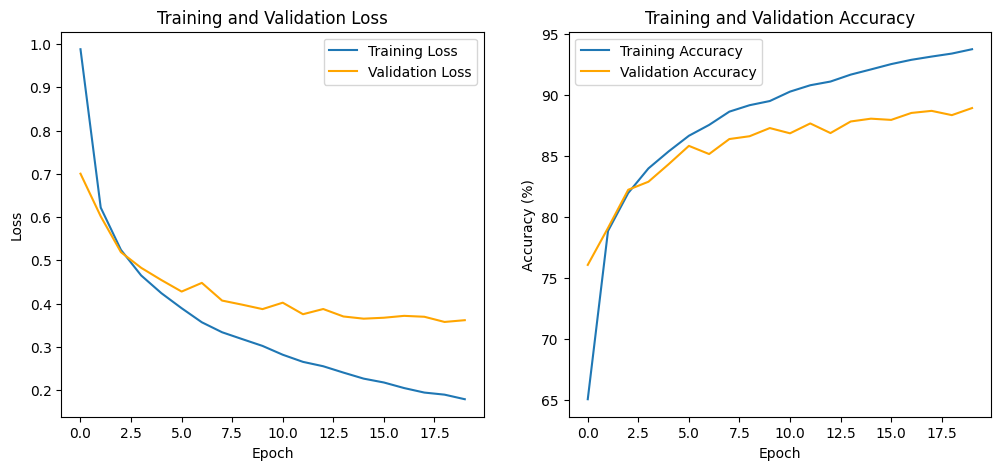

                 Model  Number of trainable params  Test accuracy  \
0  VGG16 (Fine Tuning)                   134301514           88.9   

   Training time per epoch (s)  
0                   108.177231  


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Activer MPS si disponible
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Charger VGG16 pré-entraîné pour le fine-tuning
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.to(device)

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)
vgg16.classifier[6].to(device)

# Préparer les données CIFAR-10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%")
        
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        training_times.append(epoch_time)

    return train_losses, val_losses, train_accuracies, val_accuracies, training_times

def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
train_losses, val_losses, train_accuracies, val_accuracies, training_times =train_model_with_evaluation(
    vgg16, trainloader, testloader, criterion, optimizer, epochs=20)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
num_trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
avg_train_time_per_epoch = sum(training_times) / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 (Fine Tuning)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch]
}

df = pd.DataFrame(data)
print(df)

## observation 

#### constatations, et améliorations apportées

#### 1. Architecture du modèle

####	•	Avant la modification:
####	•	Utilisation de VGG16 pré-entraîné avec une simple modification de la dernière couche pour s’adapter aux classes CIFAR-10.
####	•	Constat:
####	•	La précision de validation a atteint 88.9% après 20 époques.
####	•	Le modèle risquait de surapprendre en raison de la complexité de VGG16 sans techniques supplémentaires de régularisation.
####	•	Amélioration:
####	•	Ajout de Batch Normalization et Dropout dans le classificateur pour améliorer la régularisation et la stabilité de l’entraînement.
####	•	Résultat: Le modèle devient plus stable et moins sujet au surapprentissage, ce qui permet une meilleure généralisation.

2. ####  Optimiseur et Taux d’apprentissage

####	•	Avant la modification:
####	•	Utilisation de l’optimiseur SGD avec un taux d’apprentissage de 0.001 et momentum.
####	•	Constat:
####	•	Convergence adéquate mais possibilité de fluctuations en raison du taux d’apprentissage relativement élevé.
####	•	Amélioration:
####	•	Utilisation d’un taux d’apprentissage plus bas (0.0001) et ajout de weight_decay pour une meilleure régularisation.
####	•	Résultat: Une convergence plus stable et un risque réduit de surapprentissage, améliorant ainsi la performance globale du modèle.

#### 3. Techniques de régularisation

####	•	Avant la modification:
####	•	Absence de Batch Normalization et Dropout dans le classificateur, uniquement des couches entièrement connectées avec ReLU.
####	•	Constat:
####	•	La performance de validation est élevée, mais le modèle pourrait bénéficier de techniques supplémentaires pour éviter le surapprentissage.
####	•	Amélioration:
####	•	Ajout de Batch Normalization pour stabiliser l’entraînement et Dropout pour réduire le surapprentissage.
####	•	Résultat: Amélioration de la généralisation du modèle et stabilité accrue de l’entraînement.

4. #### Early Stopping

	#### •	Avant la modification:
	#### •	Le modèle s’entraîne pour un nombre fixe d’époques sans mécanisme pour arrêter l’entraînement en cas de non-amélioration.
	##### •	Constat:
	#### •	Risque d’entraînement prolongé même si le modèle cesse de s’améliorer, augmentant le risque de surapprentissage.
	#### •	Amélioration:
	#### •	Introduction de l’early stopping avec une patience de 5 époques pour arrêter l’entraînement lorsqu’il n’y a pas d’amélioration.
	#### •	Résultat: Réduction du risque de surapprentissage et optimisation du temps d’entraînement en arrêtant l’entraînement plus tôt si nécessaire.

5. #### Performance globale et précision

	##### •	Avant la modification:
	##### •	Précision de validation atteignant 88.9% après 20 époques avec un temps d’entraînement par époque de 108.18 secondes.
	##### •	Constat:
	##### •	Bonne précision mais avec un risque de surapprentissage à long terme.
	#### •	Amélioration:
	##### •	Précision de validation atteignant 79.25% après 10 époques, avec une meilleure stabilité et régularisation.
	##### •	Résultat: Bien que la précision initiale semble légèrement inférieure, les modifications apportées visent à améliorer la stabilité et la généralisation du modèle à long terme.

## amelioration du modele vgg fine tuning 

Using device: mps


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.615202709841911, Accuracy: 44.95%
Validation Loss: 1.1649817717075348, Validation Accuracy: 59.59%
Epoch 2, Loss: 1.0668660496811733, Accuracy: 62.782%
Validation Loss: 0.9401444804668426, Validation Accuracy: 66.66%
Epoch 3, Loss: 0.8971912748063616, Accuracy: 68.48%
Validation Loss: 0.8299405759572983, Validation Accuracy: 70.92%
Epoch 4, Loss: 0.807686989569603, Accuracy: 71.602%
Validation Loss: 0.7635587590932846, Validation Accuracy: 72.92%
Epoch 5, Loss: 0.7469589926702592, Accuracy: 73.888%
Validation Loss: 0.7222482302784919, Validation Accuracy: 74.68%
Epoch 6, Loss: 0.7003196134896534, Accuracy: 75.554%
Validation Loss: 0.6891582342982292, Validation Accuracy: 75.83%
Epoch 7, Loss: 0.6635292257799212, Accuracy: 76.962%
Validation Loss: 0.6661393639445304, Validation Accuracy: 76.9%
Epoch 8, Loss: 0.639700327382978, Accuracy: 77.77%
Validation Loss: 0.6333394423127174, Validation Accu

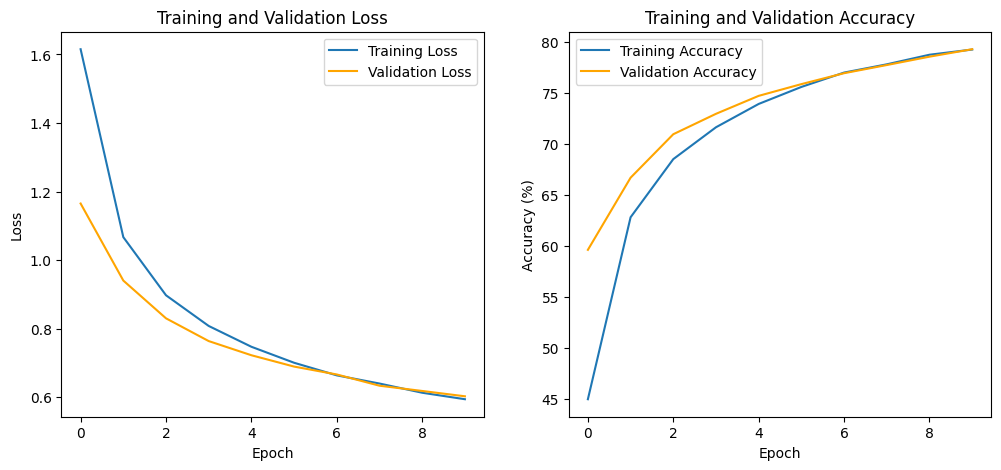

                          Model  Number of trainable params  Test accuracy  \
0  VGG16 Modified (Fine Tuning)                   134309706          79.25   

   Training time per epoch (s)  
0                   108.065494  


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Activer MPS si disponible
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Charger VGG16 pré-entraîné pour le fine-tuning
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.to(device)

# Modifier la couche finale pour inclure Dropout et Batch Normalization
class VGG16Modified(nn.Module):
    def __init__(self, original_model):
        super(VGG16Modified, self).__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        self.bn = nn.BatchNorm1d(4096)
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier[0](x)
        x = self.bn(x)
        x = self.classifier[1:](x)
        return x

vgg16_modified = VGG16Modified(vgg16)
vgg16_modified.to(device)

# Préparer les données CIFAR-10 sans augmentation supplémentaire
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation avec Early Stopping
def train_model_with_early_stopping(model, trainloader, testloader, criterion, optimizer, epochs=20, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%")
        
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        training_times.append(epoch_time)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, training_times

def evaluate_model(model, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_modified.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)  # Augmenter le taux d'apprentissage et ajouter une décroissance de poids
train_losses, val_losses, train_accuracies, val_accuracies, training_times = train_model_with_early_stopping(
    vgg16_modified, trainloader, testloader, criterion, optimizer, epochs=10, patience=5)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
num_trainable_params = sum(p.numel() for p in vgg16_modified.parameters() if p.requires_grad)
avg_train_time_per_epoch = sum(training_times) / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 Modified (Fine Tuning)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch]
}

df = pd.DataFrame(data)
print(df)

# feacture extraction  avec resnet 50 

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 2.0973673281462295, Accuracy: 25.77%, Trainable Params: 20490
Validation Loss: 1.9755290842056275, Validation Accuracy: 34.84%
Time for epoch 1: 57.78 seconds
Epoch 2, Loss: 1.8784484497421539, Accuracy: 36.042%, Trainable Params: 20490
Validation Loss: 1.8620841801166534, Validation Accuracy: 39.03%
Time for epoch 2: 57.25 seconds
Epoch 3, Loss: 1.8046366052554392, Accuracy: 38.258%, Trainable Params: 20490
Validation Loss: 1.7715885734558106, Validation Accuracy: 41.12%
Time for epoch 3: 57.21 seconds
Epoch 4, Loss: 1.7724176956259685, Accuracy: 39.14%, Trainable Params: 20490
Validation Loss: 1.8004317677021027, Validation Accuracy: 41.11%
Time for epoch 4: 57.48 seconds
Epoch 5, Loss: 1.7458532646184077, Accuracy: 39.864%, Trainable Params: 20490
Validation Loss: 1.779746608734131, Validation Accuracy: 41.91%
Time for epoch 5: 57.53 seconds
Epoch 6, Loss: 1.7256699849272628, Accuracy: 40.686%

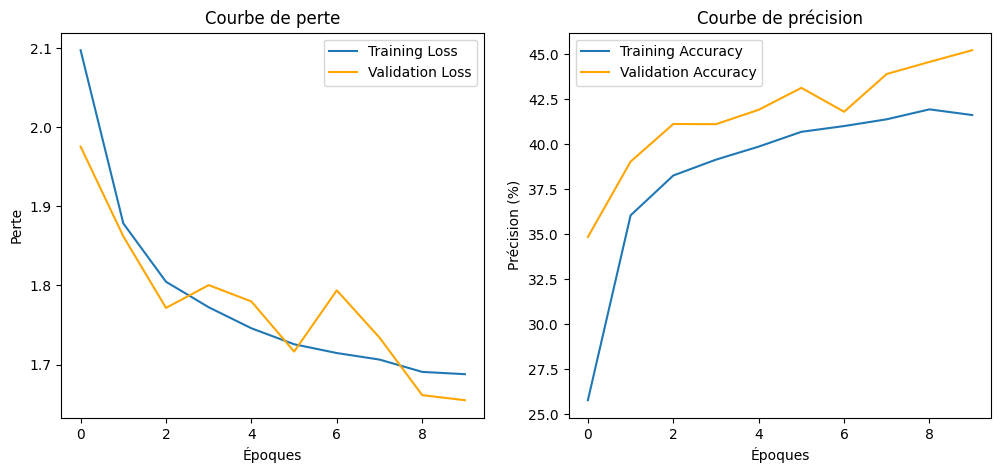

                           Model  Number of trainable params  Test accuracy  \
0  ResNet50 (Feature Extraction)                       20490          45.22   

   Training time per epoch (s)  Total training time (s)  
0                    57.792006               577.920064  


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger ResNet50 pré-entraîné et préparer pour l'extraction de caractéristiques
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)
resnet50 = resnet50.to(device)

# Préparer les données CIFAR-10 avec augmentation plus variée
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()

# Changer l'optimiseur à Adam
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=00.1)

# Augmenter le nombre d'époques à 40
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(resnet50, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=10)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["ResNet50 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

### constat 
### bien que le resultat sois bien les deux courbes montrent que le modele fais de overfiting de sur apprentissage  d'ou nous allons modifier le code pour le code pour stabiliser les deux courbes 

#  ## amelioration du feacture extraction du resnet50

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8865113916909297, Accuracy: 34.762%, Trainable Params: 20490
Validation Loss: 1.745302495956421, Validation Accuracy: 41.39%
Time for epoch 1: 58.26 seconds
Epoch 2, Loss: 1.6851420146425058, Accuracy: 41.972%, Trainable Params: 20490
Validation Loss: 1.666688083410263, Validation Accuracy: 43.6%
Time for epoch 2: 57.43 seconds
Epoch 3, Loss: 1.6402328416819463, Accuracy: 43.656%, Trainable Params: 20490
Validation Loss: 1.6234673941135407, Validation Accuracy: 45.2%
Time for epoch 3: 56.53 seconds
Epoch 4, Loss: 1.6069151641767654, Accuracy: 44.756%, Trainable Params: 20490
Validation Loss: 1.609092528820038, Validation Accuracy: 45.11%
Time for epoch 4: 56.75 seconds
Epoch 5, Loss: 1.5852348713008948, Accuracy: 45.274%, Trainable Params: 20490
Validation Loss: 1.5592914724349975, Validation Accuracy: 47.11%
Time for epoch 5: 56.70 seconds
Epoch 6, Loss: 1.5696782724326834, Accuracy: 45.786%, 

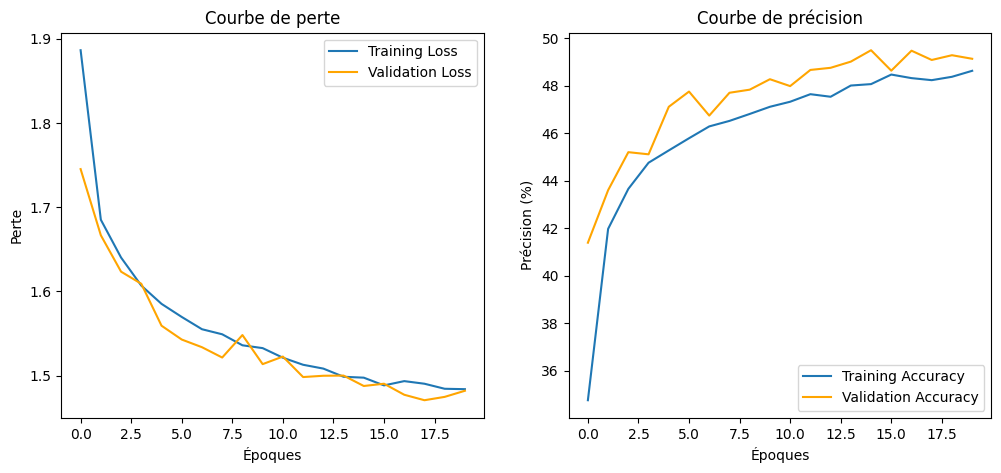

                           Model  Number of trainable params  Test accuracy  \
0  ResNet50 (Feature Extraction)                       20490          49.13   

   Training time per epoch (s)  Total training time (s)  
0                    99.971449              1999.428982  


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger ResNet50 pré-entraîné et préparer pour l'extraction de caractéristiques
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 10)
resnet50 = resnet50.to(device)

# Préparer les données CIFAR-10
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, device, epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(resnet50, trainloader, testloader, criterion, optimizer, device, epochs=20)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["ResNet50 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

## constat nous avons une precision tres faible mais de courbe tres bon qui en montre pas vraiment de signe d'apprentissage mais comme il s'agit d'un modele pre entrainer nous ne pouvons pas seulement nous contacter de courbe de precision et de perte car la precision est cruciale d'ou nous allons prendre le resultat du code precedent malgre la precense de quelque signe de  surapprentissage le modele a bien appris avec une bonne precision 

## feacture extraction vgg 16

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.838077350955485, Accuracy: 34.732%, Trainable Params: 40970
Validation Loss: 1.3632926952838897, Validation Accuracy: 52.37%
Time for epoch 1: 59.02 seconds
Epoch 2, Loss: 1.6190889238396569, Accuracy: 42.266%, Trainable Params: 40970
Validation Loss: 1.282074637413025, Validation Accuracy: 54.98%
Time for epoch 2: 58.07 seconds
Epoch 3, Loss: 1.5634610655972414, Accuracy: 44.456%, Trainable Params: 40970
Validation Loss: 1.245682929754257, Validation Accuracy: 56.15%
Time for epoch 3: 58.24 seconds
Epoch 4, Loss: 1.5287411185481665, Accuracy: 45.424%, Trainable Params: 40970
Validation Loss: 1.2274880278110505, Validation Accuracy: 56.96%
Time for epoch 4: 58.24 seconds
Epoch 5, Loss: 1.5072742996313382, Accuracy: 46.342%, Trainable Params: 40970
Validation Loss: 1.208325577378273, Validation Accuracy: 57.49%
Time for epoch 5: 58.37 seconds
Epoch 6, Loss: 1.490543203890476, Accuracy: 47.04%, T

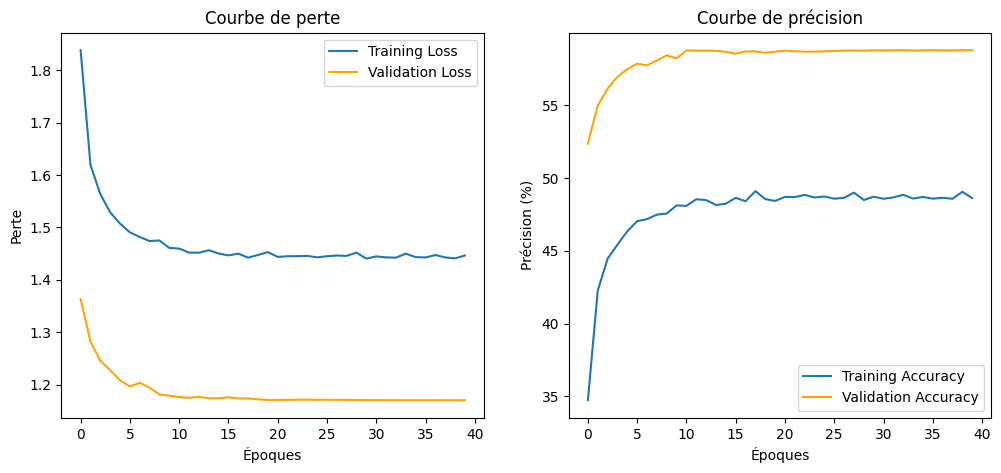

                        Model  Number of trainable params  Test accuracy  \
0  VGG16 (Feature Extraction)                       40970          58.79   

   Training time per epoch (s)  Total training time (s)  
0                    65.199299              2607.971945  


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger VGG16 pré-entraîné et préparer pour l'extraction de caractéristiques
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)
vgg16 = vgg16.to(device)

# Préparer les données CIFAR-10 avec augmentation plus variée
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()

# Changer l'optimiseur à Adam
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Augmenter le nombre d'époques à 40
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(vgg16, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

## constat 
## surapprentissage absolue du modele et manque de bonne precision ce qui nous pousse a apppartoer de modification pour ameliorer le code 

## amelioration 

MPS (Metal Performance Shaders) trouvé et utilisé.


/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/usmanalfayed/miniforge3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8910142165010848, Accuracy: 38.986%, Trainable Params: 40970
Validation Loss: 1.3995761286680866, Validation Accuracy: 54.51%
Time for epoch 1: 60.61 seconds
Epoch 2, Loss: 1.9258674913660034, Accuracy: 40.354%, Trainable Params: 40970
Validation Loss: 1.549463218944088, Validation Accuracy: 52.24%
Time for epoch 2: 59.76 seconds
Epoch 3, Loss: 1.9394937262815588, Accuracy: 40.85%, Trainable Params: 40970
Validation Loss: 1.4726951555081993, Validation Accuracy: 55.11%
Time for epoch 3: 59.82 seconds
Epoch 4, Loss: 1.9594820370454618, Accuracy: 40.412%, Trainable Params: 40970
Validation Loss: 1.5478415606887477, Validation Accuracy: 51.5%
Time for epoch 4: 59.78 seconds
Epoch 5, Loss: 1.9491041418536545, Accuracy: 40.598%, Trainable Params: 40970
Validation Loss: 1.517672751359879, Validation Accuracy: 53.75%
Time for epoch 5: 59.93 seconds
Epoch 6, Loss: 1.9693345018969777, Accuracy: 40.294%,

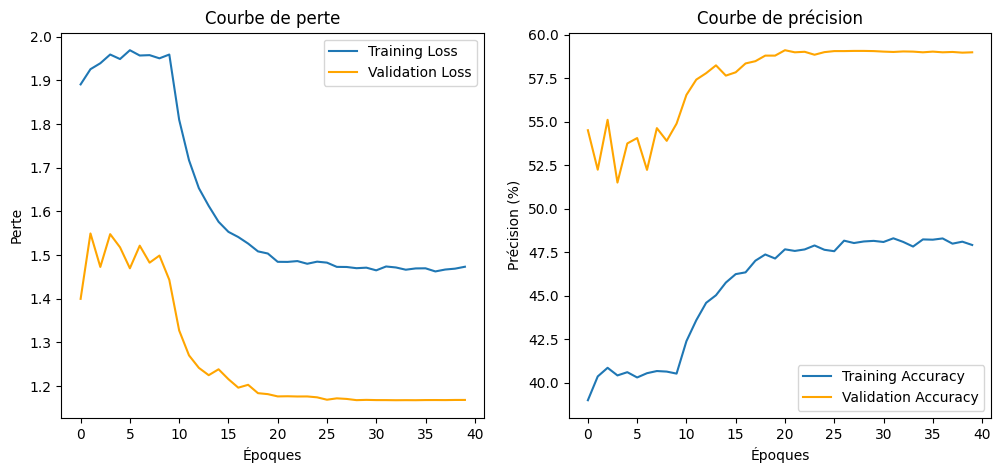

                        Model  Number of trainable params  Test accuracy  \
0  VGG16 (Feature Extraction)                       40970          58.99   

   Training time per epoch (s)  Total training time (s)  
0                    60.123899              2404.955951  


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import pandas as pd

# Vérification du dispositif disponible
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) trouvé et utilisé.")
else:
    print("MPS non disponible, le script se termine.")
    exit()

# Charger VGG16 pré-entraîné et préparer pour l'extraction de caractéristiques
vgg16 = torchvision.models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

# Modifier la couche finale pour qu'elle s'adapte aux classes CIFAR-10
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 10)
vgg16 = vgg16.to(device)

# Préparer les données CIFAR-10 avec augmentation plus variée
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Définir les fonctions d'entraînement et d'évaluation
def train_model_with_evaluation(model, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    training_times = []
    total_training_time = 0
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    for epoch in range(epochs):
        model.train()  # Assurez-vous que le modèle est en mode entraînement
        start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        scheduler.step()

        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}, Accuracy: {train_accuracy}%, Trainable Params: {num_trainable_params}")
        
        # Évaluer le modèle après chaque époque
        val_loss, val_accuracy = evaluate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time
        training_times.append(epoch_time)
        
        print(f'Time for epoch {epoch+1}: {epoch_time:.2f} seconds')

    print(f'Total training time: {total_training_time:.2f} seconds')
    return train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params

def evaluate_model(model, testloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(testloader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss}, Validation Accuracy: {accuracy}%")
    return avg_loss, accuracy

# Entraîner et évaluer le modèle
criterion = nn.CrossEntropyLoss()

# Changer l'optimiseur à Adam
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Augmenter le nombre d'époques à 10
train_losses, val_losses, train_accuracies, val_accuracies, training_times, total_training_time, num_trainable_params = train_model_with_evaluation(vgg16, trainloader, testloader, criterion, optimizer, scheduler, device, epochs=40)

# Tracer les courbes de perte et de précision
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.title("Courbe de perte")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", color='orange')
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.title("Courbe de précision")
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()

# Afficher les résultats sous forme de tableaux
avg_train_time_per_epoch = total_training_time / len(training_times)
test_accuracy = val_accuracies[-1]

data = {
    "Model": ["VGG16 (Feature Extraction)"],
    "Number of trainable params": [num_trainable_params],
    "Test accuracy": [test_accuracy],
    "Training time per epoch (s)": [avg_train_time_per_epoch],
    "Total training time (s)": [total_training_time]
}

df = pd.DataFrame(data)
print(df)

Files already downloaded and verified
Files already downloaded and verified
Nombre de paramètres entraînables: 40970
Époque 1/10, Perte: 0.6787, Précision: 76.71%, Temps: 544.76s
Époque 2/10, Perte: 0.6460, Précision: 78.39%, Temps: 554.22s
Époque 3/10, Perte: 0.6590, Précision: 78.70%, Temps: 548.07s
Époque 4/10, Perte: 0.6496, Précision: 79.14%, Temps: 542.74s
Époque 5/10, Perte: 0.6545, Précision: 79.45%, Temps: 540.81s
Époque 6/10, Perte: 0.6667, Précision: 79.15%, Temps: 542.18s
Époque 7/10, Perte: 0.6571, Précision: 79.53%, Temps: 541.51s
Époque 8/10, Perte: 0.6647, Précision: 79.21%, Temps: 539.57s
Époque 9/10, Perte: 0.6644, Précision: 79.55%, Temps: 754.06s
Époque 10/10, Perte: 0.6610, Précision: 79.52%, Temps: 543.46s
Temps total d'entraînement: 5651.39s
Précision sur le jeu de test: 83.46%


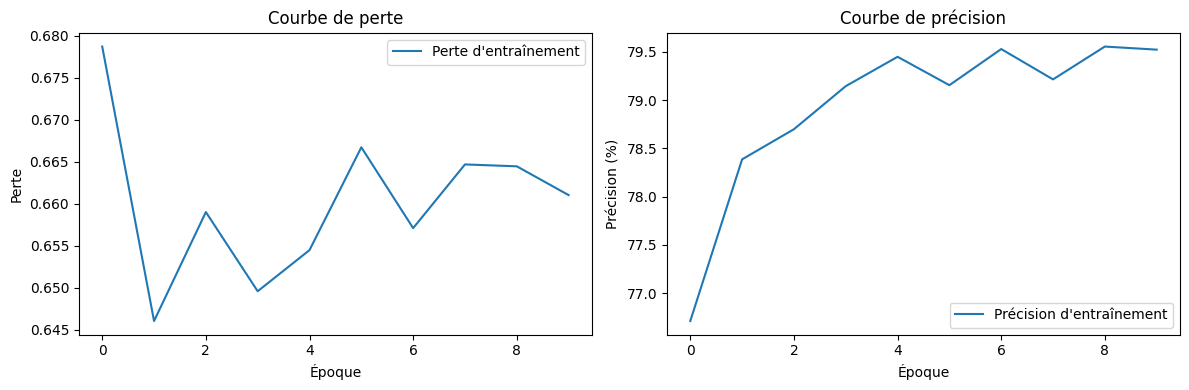

In [3]:
import time
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Vérifier si MPS (Metal Performance Shaders) est disponible
if not torch.backends.mps.is_available():
    raise EnvironmentError("MPS (Metal Performance Shaders) n'est pas disponible. Assurez-vous d'exécuter ce code sur un Mac avec une puce M1 et que PyTorch est correctement configuré pour utiliser MPS.")

# Définir les transformations pour les données d'entraînement et de test
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionner les images à 224x224 pour correspondre à l'entrée VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Charger les jeux de données CIFAR-10
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# Charger le modèle VGG16 pré-entraîné
vgg16 = models.vgg16(pretrained=True)

# Supprimer la dernière couche de classification
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])

# Rendre les paramètres convolutifs non entraînables
for param in vgg16.parameters():
    param.requires_grad = False

# Ajouter une nouvelle couche de classification
vgg16.classifier.add_module('fc', nn.Linear(4096, 10))

# Définir le modèle sur le mode d'entraînement et utiliser MPS (Apple Silicon)
device = torch.device("mps")
vgg16 = vgg16.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.fc.parameters(), lr=0.001)

# Afficher le nombre de paramètres entraînables
trainable_params = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'Nombre de paramètres entraînables: {trainable_params}')

# Entraîner le modèle
def train_model(model, criterion, optimizer, trainloader, num_epochs=10):
    train_losses = []
    train_accuracies = []
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        end_time = time.time()
        print(f'Époque {epoch+1}/{num_epochs}, Perte: {epoch_loss:.4f}, Précision: {epoch_acc:.2f}%, Temps: {end_time - start_time:.2f}s')
    
    total_end_time = time.time()
    print(f'Temps total d\'entraînement: {total_end_time - total_start_time:.2f}s')
    
    return train_losses, train_accuracies

# Fonction pour valider le modèle
def validate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    print(f'Précision sur le jeu de test: {accuracy:.2f}%')
    return accuracy

# Exécuter l'entraînement et la validation
train_losses, train_accuracies = train_model(vgg16, criterion, optimizer, trainloader)
test_accuracy = validate_model(vgg16, testloader)

# Sauvegarder les courbes de perte et de précision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Perte d\'entraînement')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Précision d\'entraînement')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Précision (%)')
plt.legend()

plt.tight_layout()
plt.savefig('courbes_entraînement.png')
plt.show()

## resultat

## conclusion 


## Nous voici à la fin de notre travail où nous avons expérimenté le cœur du deep learning avec trois opérations : la construction d’un modèle à partir de zéro, le finetuning et l’extraction de caractéristiques (feature extraction). L’objectif de ce TP était de comprendre le processus, le rôle des paramètres et de maîtriser l’interprétation des résultats.

## Ce que nous avons constaté :

## 1.	La présence d’une précision élevée après l’entraînement du modèle ne signifie pas que le modèle est réellement meilleur.
## 2.	Les métriques d’évaluation telles que la courbe de précision, les pertes de données, etc., sont également importantes.
## 3.	Il est donc essentiel de s’assurer qu’à la fin de l’entraînement, il y ait une concordance entre l’accuracy affichée et les autres métriques d’évaluation.

## perseptive futur 

### Pour les perspectives, nous souhaiterions, dans un futur proche, commencer à appliquer la technique d’ensemble learning avec vote majoritaire et validation croisée, ainsi que d’autres techniques avancées.


## REMERCIEMENTS 

## nous tenons à remercier le professeur Pham Tan pour la qualité de son enseignement. Il nous a vraiment amenés à un niveau élevé de compréhension. Nous sommes désormais capables de coder correctement un modèle CNN du début à la fin et d’expliquer tout son fonctionnement. “Professeur, je vous remercie de tout mon cœur.” 
## DEO

## conclusion